In [1]:
# vikasan
import os
import findspark
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'
os.environ['SPARK_HOME'] = '/home/vik/spark-3.5.6-bin-hadoop3'  

findspark.init()

In [2]:
# vikasan
from pyspark import SparkContext
sc=SparkContext("local","Pyspark new")

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.executor.memory", "6G") \
    .config("spark.driver.memory", "6G") \
    .config("spark.sql.shuffle.partitions", "300") \
    .config("spark.memory.fraction", "0.8") \
    .getOrCreate()

25/10/24 15:38:46 WARN Utils: Your hostname, VKSN resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/10/24 15:38:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/24 15:38:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import *
from pyspark.ml.clustering import KMeansModel
from pyspark.sql.functions import *
from pyspark.ml import Pipeline

In [4]:
scaled_train_df = spark.read.parquet("file:///home/vik/BDA_miniproj/dataset/scaled_train_features_month1.parquet")
kmeans_model = KMeansModel.load("file:///home/vik/BDA_miniproj/models/kmeans_model_month1")

In [11]:
scaled_train_df.count()

5910992

In [5]:
# get the predictions (cluster assignments) for the Month 1 data
predictions_m1 = kmeans_model.transform(scaled_train_df)

In [10]:
cluster_distribution = predictions_m1.groupBy("prediction").count()

print("Cluster distribution:")
cluster_distribution.show()

Cluster distribution:


+----------+-------+
|prediction|  count|
+----------+-------+
|         1|      2|
|         4|1287221|
|         2|      1|
|         0|4623767|
|         3|      1|
+----------+-------+



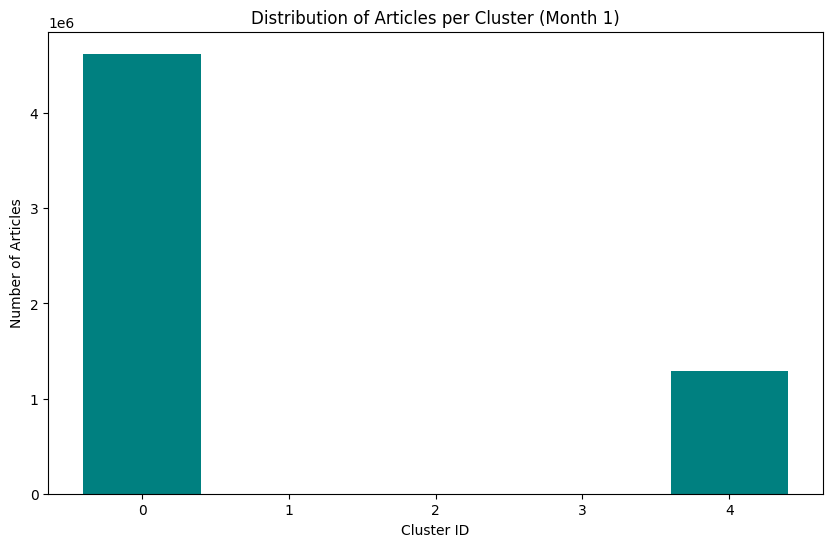

In [7]:
# plotting the cluster distribution
# Convert to pandas for easy plotting
pd_distribution = cluster_distribution.orderBy("prediction").toPandas()

plt.figure(figsize=(10, 6))
plt.bar(pd_distribution["prediction"], pd_distribution["count"], color="teal")
plt.title("Distribution of Articles per Cluster (Month 1)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Articles")
plt.xticks(pd_distribution["prediction"])
plt.show()

In [5]:
# test set
test_df2 = spark.read.parquet("file:///home/vik/BDA_miniproj/dataset/final_test_clickstream_m2.parquet")    #wsl-vik
in_agg_m2 = test_df2.groupBy("curr").agg(
    countDistinct("prev").alias("in_degree"),
    sum(col("normalized_clicks")).alias("in_clicks"),
    count("*").alias("in_events")
)

out_agg_m2 = test_df2.groupBy("prev").agg(
    countDistinct("curr").alias("out_degree"),
    sum(col("normalized_clicks")).alias("out_clicks"),
    count("*").alias("out_events")
).withColumnRenamed("prev", "curr")

article_features_m2 = in_agg_m2.join(out_agg_m2, on="curr", how="full_outer").fillna(0)

article_features_m2 = article_features_m2.withColumn(
    "ratio_out_in", (col("out_clicks") / (col("in_clicks") + lit(1.0)))
).withColumn(
    "bounce_rate", 1 - (col("out_clicks") / (col("in_clicks") + lit(1.0)))
).withColumn(
    "in_out_event_ratio", (col("in_events") / (col("out_events") + lit(1.0)))
)

# Assembling Month 2 features
feature_cols = [
    "in_degree", "out_degree",
    "in_clicks", "out_clicks",
    "ratio_out_in", "bounce_rate", "in_out_event_ratio"
]

In [6]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
kmeans = KMeans(featuresCol="features", predictionCol="prediction", k=10, seed=42)

pipeline = Pipeline(stages=[assembler, scaler, kmeans])
pipeline_model = pipeline.fit(article_features_m2)

# Extract trained models for later reuse
scaler_model = pipeline_model.stages[1]
kmeans_model = pipeline_model.stages[2]

In [7]:
assembled_m2 = assembler.transform(article_features_m2)

In [8]:
scaled_test_df = scaler_model.transform(assembled_m2).select("curr", "features")

In [9]:
predictions_m2 = kmeans_model.transform(scaled_test_df)

cluster_centers = kmeans_model.clusterCenters()

In [10]:
cluster_distribution2 = predictions_m2.groupBy("prediction").count()

# print("Cluster distribution:")
# cluster_distribution.show()

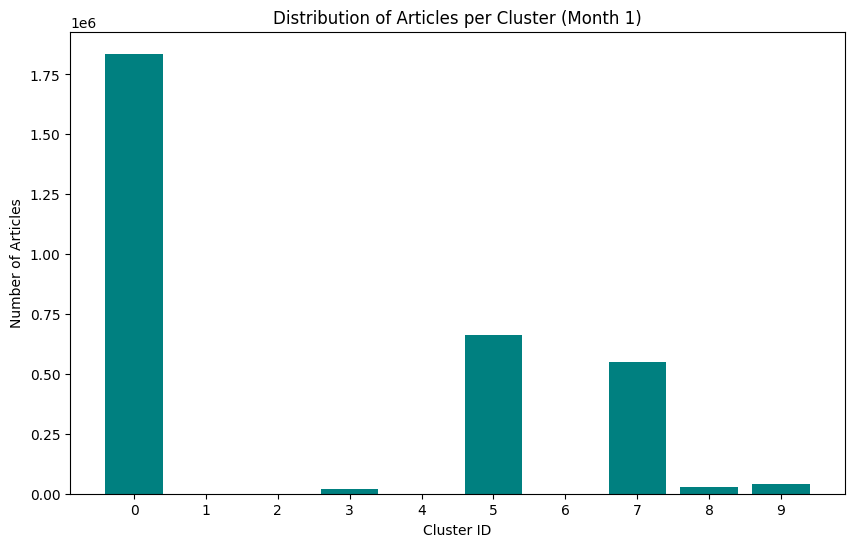

In [12]:
# plotting the cluster distribution
# Convert to pandas for easy plotting
pd_distribution2 = cluster_distribution2.orderBy("prediction").toPandas()

plt.figure(figsize=(10, 6))
plt.bar(pd_distribution2["prediction"], pd_distribution2["count"], color="teal")
plt.title("Distribution of Articles per Cluster (Month 1)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Articles")
plt.xticks(pd_distribution2["prediction"])
plt.show()

In [11]:
print("Cluster distribution:")
cluster_distribution2.show()

+----------+-------+
|prediction|  count|
+----------+-------+
|         8|  26764|
|         1|      1|
|         3|  18514|
|         5| 662050|
|         9|  40138|
|         7| 551549|
|         0|1836650|
|         4|      2|
|         6|      1|
|         2|      1|
+----------+-------+

